In [161]:
import os
import glob
import re
import numpy as np
import numpy.fft as fft
import mne
import matplotlib.pyplot as plt
from scipy import stats, signal
from numpy import save, load
import pandas as pd
import sklearn
from imblearn.over_sampling import SMOTE 
from sklearn.svm import SVC


In [162]:
import imblearn

### read dataset X and Y

In [163]:
def read_patient_file(base_path,subject_id,fileno):

    X=load('{}/data_chb{:02d}/features_{}_{:02d}.npy'.format(base_path,subject_id,subject_id, fileno))
    y=load('{}/data_chb{:02d}/targets_{}_{:02d}.npy'.format(base_path,subject_id,subject_id, fileno))
    
    return X,y

In [164]:
# selected_files_train={1:[2,10,14,15,17,20,30],3:[0,1,2,3,33,34,11,16],7:[11,12,2],8:[0,3,5,7,12],10:[16,19,23,1],5:[5,12,15,30], 15:[14,24,31,35,27],22:[16,21,4]}
# selected_files_test={1:[25,27],3:[35,27],7:[18,16],8:[15,19],10:[24,13],5:[21,36],15:[38],22:[27,24], 9:[10,5,6,7,11]}

In [295]:
# 
#  selected_files_train={1:[2,10,14,15,17,20,30],3:[0,10],7:[11,2],8:[0,11],10:[21,23,1,3],5:[5,12,15,30],9:[1,5], 15:[0,28],22:[16,1],23:[7,3],17:[18,0],18:[0,34]}
    # selected_files_test={1:[25,29],3:[33,12],7:[18,3],8:[15,19],10:[16,19,0,2],5:[21,36],15:[4,26],22:[27,0], 9:[18,13],23:[0,8],17:[19,9],18:[1,28]} 
def read_data(base_path,patients, test=False):
    selected_files_train={1:[2,10,14,15,17,20,30],3:[0,1,2,3,34,11,16],7:[11,2],8:[0,11],10:[21,23,1,3],5:[5,12,15,30],9:[1,5], 15:[0,28],22:[16,1],23:[7,3],17:[18,0],18:[0,34]}
    selected_files_test={1:[25,29],3:[33,12],7:[18,3],8:[15,19],10:[16,19,0,2],5:[21,36],15:[4,26],22:[27,0], 9:[18,13],23:[0,8],17:[19,9],18:[1,28]}   
    file_dict={}
    fileidx=0
    if test:
        selected_files_train=selected_files_test
    print(base_path,patients[0],selected_files_train[patients[0]][0])
    Xnp,ynp=read_patient_file(base_path,patients[0],selected_files_train[patients[0]][0])
    file_dict[fileidx]=len(Xnp)
    fileidx+=1
    for fileno1 in selected_files_train[patients[0]][1:]:
        X_add, y_add= read_patient_file(base_path,patients[0],fileno1)
        Xnp=np.concatenate((Xnp,X_add))
        ynp=np.concatenate((ynp,y_add))
        file_dict[fileidx]=len(Xnp)
        print(len(ynp))
        fileidx+=1
    for subject_id in (patients[1:]):
        for fileno in (selected_files_train[subject_id]):
                X_add, y_add= read_patient_file(base_path,subject_id,fileno)
                print(X_add.shape)
                Xnp=np.concatenate((Xnp,X_add))
                ynp=np.concatenate((ynp,y_add))
                file_dict[fileidx]=len(Xnp)
                fileidx+=1
    return Xnp,ynp, file_dict
    


In [296]:
X_train,y_train, files_train=read_data('10sec_notwelch',[3,5,7,8,9,10,15,17,18,22,23])
print(X_train.shape,y_train.shape)
Xsum_train,ysum_train, sumfiles_train=read_data('sum_10',[3,5,7,8,9,10,15,17,18,22,23])
print(Xsum_train.shape,ysum_train.shape)

10sec_notwelch 3 0
1427
2141
2854
3566
4284
5002
(714, 208)
(715, 208)
(712, 208)
(718, 208)
(2871, 208)
(2878, 208)
(714, 208)
(718, 208)
(2878, 208)
(2870, 208)
(1435, 208)
(1430, 208)
(1438, 208)
(1438, 208)
(718, 208)
(701, 208)
(718, 208)
(712, 208)
(780, 208)
(1007, 208)
(712, 208)
(718, 208)
(2878, 208)
(2866, 208)
(38341, 208) (38341,)
sum_10 3 0
1427
2141
2854
3566
4284
5002
(714, 3)
(715, 3)
(712, 3)
(718, 3)
(2871, 3)
(2878, 3)
(714, 3)
(718, 3)
(2878, 3)
(2870, 3)
(1435, 3)
(1430, 3)
(1438, 3)
(1438, 3)
(718, 3)
(701, 3)
(718, 3)
(712, 3)
(780, 3)
(1007, 3)
(712, 3)
(718, 3)
(2878, 3)
(2866, 3)
(38341, 3) (38341,)


In [297]:
files_train

{0: 715,
 1: 1427,
 2: 2141,
 3: 2854,
 4: 3566,
 5: 4284,
 6: 5002,
 7: 5716,
 8: 6431,
 9: 7143,
 10: 7861,
 11: 10732,
 12: 13610,
 13: 14324,
 14: 15042,
 15: 17920,
 16: 20790,
 17: 22225,
 18: 23655,
 19: 25093,
 20: 26531,
 21: 27249,
 22: 27950,
 23: 28668,
 24: 29380,
 25: 30160,
 26: 31167,
 27: 31879,
 28: 32597,
 29: 35475,
 30: 38341}

In [298]:
    def generate_column_names():
        channel_order= {'FP1-F7':0, 'F7-T7':1, 'T7-P7':2, 'P7-O1':3, 'FP1-F3':4, 'F3-C3':5, 'C3-P3':6, 'P3-O1':7, 'FP2-F4':8, 'F4-C4':9, 'C4-P4':10, 'P4-O2':11, 'FP2-F8':12, 'F8-T8':13, 'T8-P8-0':14, 'P8-O2':15, 'FZ-CZ':16, 'CZ-PZ':17, 'P7-T7':18, 'T7-FT9':19, 'FT9-FT10':20, 'FT10-T8':21 ,'T8-P8-1':22 }
        # channel_order= {0:'FP1-F7', 1:'F7-T7', 2:'T7-P7', 3:'P7-O1', 4:'FP1-F3', 5:'F3-C3', 6:'C3-P3', 7:'P3-O1', 8:'FP2-F4', 9:'F4-C4', 10:'C4-P4', 11:'P4-O2', 12:'FP2-F8', 13:'F8-T8', 14:'T8-P8', 15:'P8-O2', 16:'FZ-CZ', 17:'CZ-PZ', 18:'P7-T7', 19:'T7-FT9', 20:'FT9-FT10', 21:'FT10-T8' ,22:'T8-P8' }
        col_names=[]
        for ch in channel_order:
            # print(ch)
            for i in range(0,9):
                col_names.append(str(ch)+'-'+str(i))
        # col_names.append('rms')
        # col_names.append('sum')
        col_names.append('patient')
        # print(col_names.shape)
        return col_names


In [299]:
df_sums =pd.DataFrame(data=Xsum_train , columns=['sum', 'rms', 'patient'])
df_sums

,sum,rms,patient
0,5846.500000,0.864674,3.0
1,6380.655762,0.945070,3.0
2,3502.799316,0.908617,3.0
3,2771.754639,0.969138,3.0
4,2775.887207,0.986501,3.0
...,...,...,...
38336,25640.431641,2.393147,23.0
38337,30569.257812,2.766338,23.0
38338,35951.238281,3.532748,23.0
38339,45201.796875,4.571831,23.0


In [300]:
df=pd.DataFrame(data=X_train, columns=generate_column_names())

df=df.drop(['T8-P8-1-0', 'T8-P8-1-1', 'T8-P8-1-2', 'T8-P8-1-3', 'T8-P8-1-4', 'T8-P8-1-5', 'T8-P8-1-6', 'T8-P8-1-7', 'T8-P8-1-8'], axis=1)
# df['sum']=df_sums['sum']
# df['rms']=df_sums['rms']
# df['patient']=df_sums['patient']
# df=df[['FP2-F8-6','FP2-F8-1']]

# df=df.drop(['P8-O2-4','P3-O1-5','FZ-CZ-0','FP2-F8-4','P7-O1-4','FT9-FT10-5','FP1-F3-0','F4-C4-0','C3-P3-0','FP1-F3-3',
# 'C4-P4-3','FP1-F7-1','P8-O2-1','P4-O2-1','F7-T7-1','T7-FT9-2','P4-O2-3','P8-O2-3','P7-O1-1','P4-O2-0','T7-FT9-1','P8-O2-0','F8-T8-1','T7-FT9-3','T7-FT9-0','FP2-F8-1'], axis=1)


df['target']=y_train
df['file']=files_train[0]
for i in range(1,len(files_train)):
    print(files_train[i])
    df['file'][max(0, files_train[i-1]):files_train[i]]=files_train[i]
print(df.shape)
df=df.dropna()
print(df.shape)
df.reset_index(drop=True, inplace=True)

1427
2141
2854
3566
4284
5002
5716
6431
7143
7861
10732
13610
14324
15042
17920
20790
22225
23655
25093
26531
27249
27950
28668
29380
30160
31167
31879
32597
35475
38341
(38341, 201)


C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(38341, 201)


In [301]:
# df['file']=files_train[0]
# df['file'].unique()

In [302]:
df

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,FT10-T8-2,FT10-T8-3,FT10-T8-4,FT10-T8-5,FT10-T8-6,FT10-T8-7,FT10-T8-8,patient,target,file
0,0.048201,0.157622,0.102184,0.059907,0.212427,0.065740,0.299087,0.061449,306.631836,0.066712,...,0.004167,0.005322,0.287931,0.108200,0.518252,0.032691,325.362610,3.0,2,715
1,0.046769,0.158111,0.102100,0.060788,0.250879,0.057868,0.271288,0.059697,315.222168,0.059275,...,0.003365,0.004386,0.293018,0.068229,0.511900,0.035652,341.035522,3.0,2,715
2,0.020402,0.162911,0.069030,0.031672,0.274410,0.059100,0.285805,0.080117,238.446213,0.056112,...,0.004609,0.006674,0.105834,0.055743,0.742071,0.026055,171.485550,3.0,2,715
3,0.019260,0.153968,0.106827,0.035857,0.247914,0.059991,0.281614,0.078994,189.872879,0.049146,...,0.006714,0.009055,0.093702,0.026342,0.764540,0.021502,163.732895,3.0,2,715
4,0.025350,0.173266,0.111380,0.043829,0.198319,0.056620,0.308731,0.071359,174.227905,0.032688,...,0.005278,0.008828,0.104378,0.018269,0.746446,0.017827,167.738052,3.0,2,715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38336,0.079578,0.270041,0.090994,0.093018,0.243415,0.043488,0.177901,0.035912,488.916565,0.017821,...,0.026480,0.043987,0.278894,0.059370,0.277519,0.054045,1458.102905,23.0,0,38341
38337,0.148380,0.261689,0.151540,0.166786,0.210550,0.020178,0.084014,0.019089,1240.562500,0.016599,...,0.030967,0.058878,0.288127,0.049539,0.241488,0.053769,1694.957153,23.0,0,38341
38338,0.147811,0.271728,0.144606,0.167636,0.223418,0.019329,0.074082,0.015947,1239.608154,0.009802,...,0.016457,0.035156,0.319332,0.067543,0.263723,0.057352,1486.628418,23.0,0,38341
38339,0.014488,0.080790,0.009014,0.012463,0.185675,0.035517,0.409711,0.171553,3440.663574,0.006922,...,0.003273,0.006855,0.303414,0.089496,0.330681,0.071033,1247.128540,23.0,0,38341


In [303]:
X_test,y_test,files_test=read_data('10sec_notwelch',[3,5,7,8,9,10,15,17,18,22,23], test=True)
print(X_test.shape,y_test.shape)
Xsum_test,ysum_test, sumfiles_test=read_data('sum_10',[3,5,7,8,9,10,15,17,18,22,23],test=True)
print(Xsum_test.shape,ysum_test.shape)

10sec_notwelch 3 33
1431
(712, 208)
(718, 208)
(2873, 208)
(2878, 208)
(712, 208)
(723, 208)
(1130, 208)
(2881, 208)
(1433, 208)
(1434, 208)
(1442, 208)
(1438, 208)
(714, 208)
(718, 208)
(718, 208)
(718, 208)
(955, 208)
(881, 208)
(712, 208)
(718, 208)
(1488, 208)
(1000, 208)
(28427, 208) (28427,)
sum_10 3 33
1431
(712, 3)
(718, 3)
(2873, 3)
(2878, 3)
(712, 3)
(723, 3)
(1130, 3)
(2881, 3)
(1433, 3)
(1434, 3)
(1442, 3)
(1438, 3)
(714, 3)
(718, 3)
(718, 3)
(718, 3)
(955, 3)
(881, 3)
(712, 3)
(718, 3)
(1488, 3)
(1000, 3)
(28427, 3) (28427,)


In [304]:
test_df_sums =pd.DataFrame(data=Xsum_test , columns=['sum', 'rms', 'patient'])
test_df_sums

,sum,rms,patient
0,4.957877e+04,95.773201,3.0
1,6.099483e+05,93.544350,3.0
2,1.019857e+06,101.394424,3.0
3,4.614634e+05,95.406693,3.0
4,2.295779e+05,107.049828,3.0
...,...,...,...
28422,1.274652e+05,14.796249,23.0
28423,7.935131e+04,7.171244,23.0
28424,2.892023e+04,2.277688,23.0
28425,1.894423e+04,1.401772,23.0


In [305]:
test_df=pd.DataFrame(data=X_test, columns=generate_column_names())

test_df=test_df.drop(['T8-P8-1-0', 'T8-P8-1-1', 'T8-P8-1-2', 'T8-P8-1-3', 'T8-P8-1-4', 'T8-P8-1-5', 'T8-P8-1-6', 'T8-P8-1-7', 'T8-P8-1-8'], axis=1)

# test_df['sum']=test_df_sums['sum']
# test_df['rms']=test_df_sums['rms']
# test_df=test_df[['FP2-F8-6','FP2-F8-1']]
# test_df=test_df.drop(['P8-O2-4','P3-O1-5','FZ-CZ-0','FP2-F8-4','P7-O1-4','FT9-FT10-5','FP1-F3-0','F4-C4-0','C3-P3-0','FP1-F3-3',
# 'C4-P4-3','FP1-F7-1','P8-O2-1','P4-O2-1','F7-T7-1','T7-FT9-2','P4-O2-3','P8-O2-3','P7-O1-1','P4-O2-0','T7-FT9-1','P8-O2-0','F8-T8-1','T7-FT9-3','T7-FT9-0','FP2-F8-1'], axis=1)

test_df['target']=y_test
test_df['file']=files_test[0]
for i in range(1,len(files_test)):
    print(files_test[i])
    test_df['file'][max(0, files_test[i-1]):files_test[i]]=files_test[i]
print(test_df.shape)
test_df=test_df.dropna()
print(test_df.shape)
test_df.reset_index(drop=True, inplace=True)


1431
2143
2861
5734
8612
9324
10047
11177
14058
15491
16925
18367
19805
20519
21237
21955
22673
23628
24509
25221
25939
27427
28427
(28427, 201)


C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


(28422, 201)


In [306]:
df

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,FT10-T8-2,FT10-T8-3,FT10-T8-4,FT10-T8-5,FT10-T8-6,FT10-T8-7,FT10-T8-8,patient,target,file
0,0.048201,0.157622,0.102184,0.059907,0.212427,0.065740,0.299087,0.061449,306.631836,0.066712,...,0.004167,0.005322,0.287931,0.108200,0.518252,0.032691,325.362610,3.0,2,715
1,0.046769,0.158111,0.102100,0.060788,0.250879,0.057868,0.271288,0.059697,315.222168,0.059275,...,0.003365,0.004386,0.293018,0.068229,0.511900,0.035652,341.035522,3.0,2,715
2,0.020402,0.162911,0.069030,0.031672,0.274410,0.059100,0.285805,0.080117,238.446213,0.056112,...,0.004609,0.006674,0.105834,0.055743,0.742071,0.026055,171.485550,3.0,2,715
3,0.019260,0.153968,0.106827,0.035857,0.247914,0.059991,0.281614,0.078994,189.872879,0.049146,...,0.006714,0.009055,0.093702,0.026342,0.764540,0.021502,163.732895,3.0,2,715
4,0.025350,0.173266,0.111380,0.043829,0.198319,0.056620,0.308731,0.071359,174.227905,0.032688,...,0.005278,0.008828,0.104378,0.018269,0.746446,0.017827,167.738052,3.0,2,715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38336,0.079578,0.270041,0.090994,0.093018,0.243415,0.043488,0.177901,0.035912,488.916565,0.017821,...,0.026480,0.043987,0.278894,0.059370,0.277519,0.054045,1458.102905,23.0,0,38341
38337,0.148380,0.261689,0.151540,0.166786,0.210550,0.020178,0.084014,0.019089,1240.562500,0.016599,...,0.030967,0.058878,0.288127,0.049539,0.241488,0.053769,1694.957153,23.0,0,38341
38338,0.147811,0.271728,0.144606,0.167636,0.223418,0.019329,0.074082,0.015947,1239.608154,0.009802,...,0.016457,0.035156,0.319332,0.067543,0.263723,0.057352,1486.628418,23.0,0,38341
38339,0.014488,0.080790,0.009014,0.012463,0.185675,0.035517,0.409711,0.171553,3440.663574,0.006922,...,0.003273,0.006855,0.303414,0.089496,0.330681,0.071033,1247.128540,23.0,0,38341


In [307]:
df['file'].unique()

array([  715,  1427,  2141,  2854,  3566,  4284,  5002,  5716,  6431,
        7143,  7861, 10732, 13610, 14324, 15042, 17920, 20790, 22225,
       23655, 25093, 26531, 27249, 27950, 28668, 29380, 30160, 31167,
       31879, 32597, 35475, 38341], dtype=int64)

In [308]:
test_df['file'].unique()

array([  713,  1431,  2143,  2861,  5734,  8612,  9324, 10047, 11177,
       14058, 15491, 16925, 18367, 19805, 20519, 21237, 21955, 22673,
       23628, 24509, 25221, 25939, 27427, 28427], dtype=int64)

In [309]:
# check_df=pd.merge(test_df,df, how='inner', on='F7-T7-0')
# check_df

In [310]:
# test_df['FP1-F7-2'].duplicated().sum()

In [311]:
test_df[test_df['target']==2]

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,FT10-T8-2,FT10-T8-3,FT10-T8-4,FT10-T8-5,FT10-T8-6,FT10-T8-7,FT10-T8-8,patient,target,file
275,0.345117,0.215752,0.140790,0.227060,0.074075,0.019202,0.119332,0.023635,103.492218,0.332988,...,0.108799,0.166220,0.091261,0.018341,0.119291,0.035537,68.719315,3.0,2,713
276,0.274128,0.174400,0.164891,0.208199,0.107044,0.025304,0.154591,0.026327,132.912552,0.125679,...,0.108201,0.225750,0.135278,0.021998,0.132691,0.042639,76.052429,3.0,2,713
277,0.165978,0.135530,0.105011,0.087325,0.208076,0.056750,0.264505,0.044742,93.410263,0.045875,...,0.049041,0.154183,0.191946,0.035652,0.205347,0.067022,55.358086,3.0,2,713
278,0.124761,0.144186,0.058100,0.087162,0.238440,0.054093,0.293636,0.051838,73.900223,0.094447,...,0.052497,0.152051,0.188143,0.036864,0.229886,0.072154,49.770725,3.0,2,713
279,0.104311,0.177182,0.051509,0.085816,0.236868,0.060274,0.294471,0.057189,73.545120,0.138728,...,0.055765,0.174463,0.179008,0.033693,0.210690,0.068750,50.327126,3.0,2,713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26716,0.047990,0.269458,0.095742,0.091373,0.319937,0.047622,0.136114,0.021941,840.048828,0.021213,...,0.019929,0.035879,0.261668,0.065748,0.360759,0.087087,452.218597,23.0,2,27427
26717,0.029265,0.102525,0.055700,0.052262,0.209408,0.105233,0.362697,0.095085,2500.691406,0.005893,...,0.038105,0.046453,0.271590,0.046552,0.277675,0.068206,2013.898071,23.0,2,27427
26718,0.023050,0.071021,0.056553,0.033507,0.183386,0.104727,0.363121,0.129374,4454.954102,0.004736,...,0.037318,0.052739,0.231332,0.042542,0.270893,0.075887,6312.186523,23.0,2,27427
26719,0.008360,0.075753,0.013643,0.010454,0.203328,0.076638,0.439345,0.141022,15156.738281,0.003627,...,0.022740,0.048023,0.324108,0.042393,0.209819,0.086242,14337.091797,23.0,2,27427


In [312]:
# df[generate_column_names()[:-10]].duplicated().sum()

In [313]:
df['file'].unique()

array([  715,  1427,  2141,  2854,  3566,  4284,  5002,  5716,  6431,
        7143,  7861, 10732, 13610, 14324, 15042, 17920, 20790, 22225,
       23655, 25093, 26531, 27249, 27950, 28668, 29380, 30160, 31167,
       31879, 32597, 35475, 38341], dtype=int64)

modifying preictal intervals

In [314]:
# for ind in df.index:
#     if df['target'].iloc[ind]==2 and df['target'].iloc[ind-1]==3:
#         for i in range(ind-60,ind):
#             if (df['target'].iloc[i]==3 or df['target'].iloc[i]==3) and df['file'].iloc[i]==df['file'].iloc[ind]:
#                 # print(df[['target','file']].iloc[i])
#                 df.at[i,'target']=2

# for ind in df.index:
#     if df['target'].iloc[ind]==2 and df['target'].iloc[ind-1]==3:
#         for i in range(ind-180,ind):
#             if (df['target'].iloc[i]==3 or df['target'].iloc[i]==3) and df['file'].iloc[i]==df['file'].iloc[ind]:
#                 # print(df[['target','file']].iloc[i])
#                 df.at[i,'target']=4

In [315]:
# for ind in test_df.index:
#     if test_df['target'].iloc[ind]==2 and test_df['target'].iloc[ind-1]==3:
#         for i in range(ind-60,ind):
#             if (test_df['target'].iloc[i]==3 or test_df['target'].iloc[i]==3) and test_df['file'].iloc[i]==test_df['file'].iloc[ind]:
#                 # print(test_df[['target','file']].iloc[i])
#                 test_df.at[i,'target']=2

# for ind in test_df.index:
#     if test_df['target'].iloc[ind]==2 and test_df['target'].iloc[ind-1]==3:
#         for i in range(ind-180,ind):
#             if (test_df['target'].iloc[i]==3 or test_df['target'].iloc[i]==3) and test_df['file'].iloc[i]==test_df['file'].iloc[ind]:
#                 # print(test_df[['target','file']].iloc[i])
#                 test_df.at[i,'target']=4

cleaning labels

In [316]:
for f in df['file'].unique():
    # print(f)
    temp_file_df=df[df['file']==f]
    if 2 in temp_file_df['target'].unique():
        # print(df[df['file']==f]['target'].unique())
        df['target'][(df['target']==0) & (df['file']==f)]=3
    # print(df[df['file']==f]['target'].unique())

for f in df['file'].unique():
    # print(f)
    temp_file_df=df[df['file']==f]
    if 2 in temp_file_df['target'].unique():
        for ind in range(temp_file_df.index.min(),temp_file_df.index.max()-1):
            # print('index'+str(ind)+"    "+str(len(temp_file_df)))
            if temp_file_df['target'].loc[ind]==2 and temp_file_df['target'].loc[ind+1]!=2:
                df['target'][ind+1:f]=3
        


C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\salma\AppData\Roaming\Python\Py

Cleaning labels

In [317]:
for f in test_df['file'].unique():
    # print(f)
    temp_file_df=test_df[test_df['file']==f]
    if 2 in temp_file_df['target'].unique():
        # print(test_df[test_df['file']==f]['target'].unique())
        test_df['target'][(test_df['target']==0) & (test_df['file']==f)]=3
    # print(test_df[test_df['file']==f]['target'].unique())
    
for f in test_df['file'].unique():
    # print(f)
    temp_file_df=test_df[test_df['file']==f]
    if 2 in temp_file_df['target'].unique():
        for ind in range(temp_file_df.index.min(),temp_file_df.index.max()-1):
            if temp_file_df['target'].loc[ind]==2 and temp_file_df['target'].loc[ind+1]!=2:
                test_df['target'][ind+1:f]=3
        

C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\salma\AppData\Roaming\Python\Py

In [318]:
# df['ratio']= df['sum']/df['rms']
# test_df['ratio']= test_df['sum']/test_df['rms']


In [319]:
df['target'].unique()

array([2, 3, 0], dtype=int64)

In [320]:
df['target'][225:343].unique()

array([3], dtype=int64)

In [321]:
# import statsmodels.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# data=df.drop(['patient','target','file'], axis=1)
# X = data[data.columns]

# # VIF dataframe
# vif_data = pd.DataFrame()
# vif_data["feature"] = X.columns

# # calculating VIF for each feature
# vif_data["VIF"] = [variance_inflation_factor(X.values, i)
# 						for i in range(len(X.columns))]

# print(vif_data)


In [322]:
# vif_data[vif_data['VIF']<50]['feature']

## Prepare training data

In [1515]:
oneout=23

In [1516]:
train_df=df
train_df=train_df[(train_df['target']==0) | (train_df['target']==2) | (train_df['target']==4)]
train_df=train_df[(train_df['patient'] != oneout)]
# train_df=train_df.drop(['patient'], axis=1)



In [1517]:
train_df['patient'].unique()

array([ 3.,  5.,  7.,  8.,  9., 10., 15., 17., 18., 22.])

## Prepare test data

In [1518]:
# chunk_size=3
# test_files=test_df['file'].unique()
# print(test_files)
# test_indices=[]
# for f in test_files:
#     temp_df=test_df[test_df['file']==f]
#     test_idx=0
#     idx_limit=temp_df.index[0]
#     while test_idx+chunk_size<len(temp_df):
#         # print(temp_df.index[0])
#         test_indices.append((test_idx+idx_limit,idx_limit+test_idx+chunk_size))
#         test_idx+=chunk_size
# print(test_indices)
#         # test_chunks=np.concatenate((test_chunk,test_df[test_df['file']==test_files[0]][0:chunk_size]))

In [1519]:
test_df[test_df['target']==2]

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,FT10-T8-2,FT10-T8-3,FT10-T8-4,FT10-T8-5,FT10-T8-6,FT10-T8-7,FT10-T8-8,patient,target,file
275,0.345117,0.215752,0.140790,0.227060,0.074075,0.019202,0.119332,0.023635,103.492218,0.332988,...,0.108799,0.166220,0.091261,0.018341,0.119291,0.035537,68.719315,3.0,2,713
276,0.274128,0.174400,0.164891,0.208199,0.107044,0.025304,0.154591,0.026327,132.912552,0.125679,...,0.108201,0.225750,0.135278,0.021998,0.132691,0.042639,76.052429,3.0,2,713
277,0.165978,0.135530,0.105011,0.087325,0.208076,0.056750,0.264505,0.044742,93.410263,0.045875,...,0.049041,0.154183,0.191946,0.035652,0.205347,0.067022,55.358086,3.0,2,713
278,0.124761,0.144186,0.058100,0.087162,0.238440,0.054093,0.293636,0.051838,73.900223,0.094447,...,0.052497,0.152051,0.188143,0.036864,0.229886,0.072154,49.770725,3.0,2,713
279,0.104311,0.177182,0.051509,0.085816,0.236868,0.060274,0.294471,0.057189,73.545120,0.138728,...,0.055765,0.174463,0.179008,0.033693,0.210690,0.068750,50.327126,3.0,2,713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26716,0.047990,0.269458,0.095742,0.091373,0.319937,0.047622,0.136114,0.021941,840.048828,0.021213,...,0.019929,0.035879,0.261668,0.065748,0.360759,0.087087,452.218597,23.0,2,27427
26717,0.029265,0.102525,0.055700,0.052262,0.209408,0.105233,0.362697,0.095085,2500.691406,0.005893,...,0.038105,0.046453,0.271590,0.046552,0.277675,0.068206,2013.898071,23.0,2,27427
26718,0.023050,0.071021,0.056553,0.033507,0.183386,0.104727,0.363121,0.129374,4454.954102,0.004736,...,0.037318,0.052739,0.231332,0.042542,0.270893,0.075887,6312.186523,23.0,2,27427
26719,0.008360,0.075753,0.013643,0.010454,0.203328,0.076638,0.439345,0.141022,15156.738281,0.003627,...,0.022740,0.048023,0.324108,0.042393,0.209819,0.086242,14337.091797,23.0,2,27427


In [1520]:
test_df2=test_df[(test_df['target']==0) | (test_df['target']==2) | (test_df['target']==4)]
test_df2=test_df2[(test_df2['patient']==oneout)]

In [1521]:
test_df2

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,FT10-T8-2,FT10-T8-3,FT10-T8-4,FT10-T8-5,FT10-T8-6,FT10-T8-7,FT10-T8-8,patient,target,file
26603,0.008038,0.243396,0.006025,0.006369,0.488924,0.036390,0.169163,0.035481,6144.710938,0.003320,...,0.001226,0.002033,0.220546,0.081430,0.420963,0.119636,6327.415527,23.0,2,27427
26604,0.023448,0.346298,0.038891,0.025137,0.359553,0.035439,0.151338,0.032878,2455.739258,0.005464,...,0.003155,0.006516,0.263336,0.088478,0.369220,0.096059,3180.480469,23.0,2,27427
26605,0.019809,0.227808,0.030125,0.021005,0.404914,0.043992,0.208708,0.045752,2883.457520,0.007996,...,0.006924,0.015655,0.306528,0.068722,0.320767,0.077448,1398.140625,23.0,2,27427
26606,0.022122,0.237090,0.020708,0.030880,0.406082,0.046878,0.196700,0.039673,3260.713623,0.009210,...,0.002871,0.004328,0.315315,0.077230,0.360022,0.077128,1606.806885,23.0,2,27427
26607,0.045729,0.278994,0.040473,0.052151,0.381563,0.040571,0.144541,0.025225,2130.703613,0.010678,...,0.003019,0.005168,0.322123,0.073172,0.347212,0.071153,1345.146484,23.0,2,27427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28417,0.002457,0.054487,0.003277,0.001909,0.214779,0.108236,0.413591,0.136638,33661.929688,0.002544,...,0.001440,0.002251,0.217874,0.070852,0.426471,0.144180,5211.921875,23.0,0,28427
28418,0.002917,0.063094,0.008815,0.004151,0.244035,0.085063,0.366524,0.136561,15315.038086,0.001891,...,0.002927,0.002315,0.225164,0.078160,0.413792,0.143398,6023.356445,23.0,0,28427
28419,0.019732,0.088986,0.052930,0.041488,0.235008,0.053195,0.374253,0.113356,1258.034546,0.012950,...,0.005838,0.003898,0.214447,0.104011,0.403189,0.123505,3600.833252,23.0,0,28427
28420,0.062056,0.179934,0.173931,0.124868,0.253153,0.035388,0.168892,0.049304,353.723450,0.040335,...,0.010174,0.010818,0.189293,0.084218,0.428457,0.108510,1867.094360,23.0,0,28427


In [1522]:
test_df2['target'].unique()

array([2, 0], dtype=int64)

In [1523]:
X_train1 = np.array(train_df.drop(['target','patient','file'], axis=1))
y_train1 = np.array(train_df['target'])
X_test1 = np.array(test_df2.drop(['target','patient','file'], axis=1)).astype('float32')
y_test1  =np.array(test_df2['target']).astype('float32')

In [1524]:
# X_train1=np.array(train_df[vif_data[vif_data['VIF']<300000000]['feature']])
# X_test1=np.array(test_df2[vif_data[vif_data['VIF']<300000000]['feature']])

In [1525]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train1, y_train1)
X_resampled_test, y_resampled_test = rus.fit_resample(X_test1, y_test1)


In [1526]:
test_df.shape

(28422, 201)

In [1527]:
X_train=np.array(X_resampled).astype('float32')
X_test=np.array( X_resampled_test).astype('float32')
y_train=np.array(y_resampled).astype('float32')
y_test=np.array( y_resampled_test).astype('float32')

X_train_shape =X_train.shape
X_test_shape = X_test.shape
y_train_shape =y_train.shape 
y_test_shape = y_test.shape
print(X_train_shape)
print(X_test_shape)
print(y_train_shape)
print(y_test_shape)

(3730, 198)
(236, 198)
(3730,)
(236,)


### Normalization

In [1528]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# # scaler.fit(df.drop(['target', 'seizure_number', 'patient','mean_sum','mean_rms',	'sum_ratio','rms_ratio'], axis=1).append(test_df.drop(['target', 'seizure_number', 'patient','mean_sum','mean_rms',	'sum_ratio','rms_ratio'], axis=1), ignore_index=True))
# # scaler.fit(X_train)
Sc_X_train=scaler.fit_transform(X_train)
# # scaler.fit(X_test)
Sc_X_test=scaler.fit_transform(X_test)

In [1529]:
X_train.shape

(3730, 198)

### PCA

In [1530]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=100)
# Sc_X_train=pca.fit_transform(Sc_X_train)
# Sc_X_test=pca.transform(Sc_X_test)

### training the model

In [1531]:
from datetime import datetime

In [1532]:
cost: 150.0
weight_dict: {0: 1, 2: 10}

In [1533]:
before = datetime.now()
before_time =before.strftime("%H:%M:%S")
print(before_time)

clf = SVC( C=1, kernel='rbf', random_state=42)
clf.fit(Sc_X_train, y_train)
trainAcc = clf.score(Sc_X_train, y_train)
testAcc = clf.score(Sc_X_test, y_test)
print("**SVM Results:**")
print("Training Accuracy: %d"%(trainAcc*100)+"%")
print("Testing Accuracy: %d"%(testAcc *100)+"%")

after = datetime.now()
after_time =after.strftime("%H:%M:%S")
print(after_time)

17:25:18
**SVM Results:**
Training Accuracy: 96%
Testing Accuracy: 77%
17:25:25


In [1534]:
import joblib


# # print ("saving new model")
# joblib.dump(clf,"my_models/temporal{}_{}_{}.pkl".format(after_time[0:2],after_time[3:5],"f189"))

In [1535]:
# clf = joblib.load("my_models/temporal00_54_C.pkl")
# y_pred=loaded_clf.predict(X_test)
y_pred=clf.predict(scaler.fit_transform(X_test))

In [1536]:
def smooth(ser):
    window=7
    i=0
    while i < len(ser)-window:
        if ser[i]==ser[i+window]:
            ser[i:i+window]=ser[i]
        i+=1
    return np.array(ser)
clf.get_params(deep=True)

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [1537]:
print(sklearn.metrics.classification_report(y_test, y_pred,))

              precision    recall  f1-score   support

         0.0       0.74      0.86      0.80       118
         2.0       0.84      0.69      0.76       118

    accuracy                           0.78       236
   macro avg       0.79      0.78      0.78       236
weighted avg       0.79      0.78      0.78       236



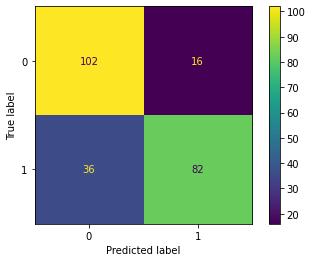

In [1538]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [1539]:
import statistics 
length=59
mode_pred=[]
mode_real=[]
for i in range(0,len(test_df2)-length, length):
    chunk=test_df2.iloc[int(i):int(i+length)]
    # print(list(chunk.columns))
    if(len(chunk['file'].unique())==1):
        chunk1 =scaler.fit_transform(chunk.drop(['file','patient','target'], axis=1))
        mode_pred.append(statistics.mode((clf.predict(np.array(chunk1)))))
        # print(y_test[int(block[0]):int(block[1])])
        mode_real.append(statistics.mode(chunk['target']))
    else:
        print(chunk['file'].unique())


In [1540]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test, y_pred).ravel()
print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))

TN:102, FP:16, FN:36, TP:82


In [1541]:
list(sklearn.metrics.confusion_matrix(y_test, y_pred).ravel())

[102, 16, 36, 82]

In [1542]:

specificity=(tn)/(tn+fp)
sensitivity=(tp)/(tp+fn)
f1_score=sklearn.metrics.f1_score(y_test, y_pred, average='micro')
auc=sklearn.metrics.roc_auc_score(y_test, y_pred)

print('specificity= {} , sensitivity= {}, f1= {}, auc={}'.format(specificity, sensitivity, f1_score, auc))

specificity= 0.864406779661017 , sensitivity= 0.6949152542372882, f1= 0.7796610169491526, auc=0.7796610169491526


In [1543]:
print(mode_pred)
print(mode_real)  
print(list(np.array(mode_pred)-np.array(mode_real)))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[-2.0, -2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


C:\Users\salma\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\salma\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\salma\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

  interictal       0.89      1.00      0.94        16
    preictal       0.00      0.00      0.00         2

    accuracy                           0.89        18
   macro avg       0.44      0.50      0.47        18
weighted avg       0.79      0.89      0.84        18



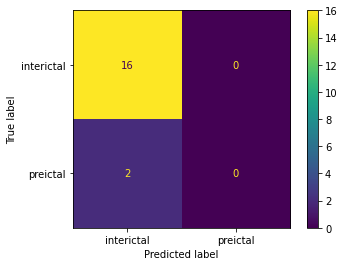

In [1544]:
cm = confusion_matrix(mode_real, mode_pred,labels=[0,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['interictal', 'preictal'])
disp.plot()
print(sklearn.metrics.classification_report(mode_real, mode_pred, labels=[0,2], target_names=['interictal', 'preictal']))

In [1545]:
from sklearn.ensemble import RandomForestClassifier

rf_start = datetime.now()
print(rf_start)


rf = RandomForestClassifier(n_estimators=50, max_depth=100, random_state=70, class_weight='balanced')
rf.fit(Sc_X_train, y_train)
trainAcc=rf.score(Sc_X_train, y_train)
testAcc=rf.score(Sc_X_test, y_test)
print("**Random Forest Results:**")
print("Training Accuracy: %d"%(trainAcc*100)+"%")
print("Testing Accuracy: %d"%(testAcc *100)+"%")

rf_finish = datetime.now()
rf_time =(rf_finish-rf_start)
print(rf_time)

2021-07-11 17:25:31.160646
**Random Forest Results:**
Training Accuracy: 100%
Testing Accuracy: 47%
0:00:06.504613


In [1546]:
rf_y_pred=rf.predict(Sc_X_test)

In [1547]:
print(sklearn.metrics.classification_report(y_test, rf_y_pred, labels=[0,2], target_names=['interictal', 'preictal']))

              precision    recall  f1-score   support

  interictal       0.49      0.78      0.60       118
    preictal       0.45      0.18      0.25       118

    accuracy                           0.48       236
   macro avg       0.47      0.48      0.43       236
weighted avg       0.47      0.48      0.43       236



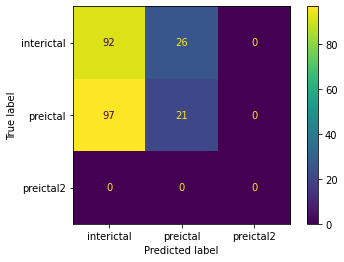

In [1548]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, rf_y_pred,labels=[0,2,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['interictal', 'preictal', 'preictal2'])
disp.plot()

In [1549]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test, rf_y_pred).ravel()
print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))

TN:92, FP:26, FN:97, TP:21


In [1550]:
specificity=(tn)/(tn+fp)
sensitivity=(tp)/(tp+fn)
f1_score=sklearn.metrics.f1_score(y_test, rf_y_pred, average='micro')

print('specificity= {} , sensitivity= {}, f1= {}'.format(specificity, sensitivity, f1_score))

specificity= 0.7796610169491526 , sensitivity= 0.17796610169491525, f1= 0.4788135593220339


In [1551]:
# # print('X size ={}, y size = {}'.format(X_shape, y_shape))
# print('interictal size ={}, preictal size = {}'.format(interictal_shape, preictal_shape))
# print('train size ={}, test size = {}'.format(X_train_shape, X_test_shape))

# print("Training Accuracy: %d"%(trainAcc*100)+"%")
# print("Testing Accuracy: %d"%(testAcc *100)+"%")
# print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))
# print('specificity= {} , sensitivity= {}, f1= {}'.format(specificity, sensitivity, f1_score))

In [1552]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0)

lr.fit(Sc_X_train, y_train)
trainAcc = lr.score(Sc_X_train, y_train)
testAcc = lr.score(Sc_X_test, y_test)
print("**SVM Results:**")
print("Training Accuracy: %d"%(trainAcc*100)+"%")
print("Testing Accuracy: %d"%(testAcc *100)+"%")

**SVM Results:**
Training Accuracy: 93%
Testing Accuracy: 80%


C:\Users\salma\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80       118
         2.0       0.79      0.85      0.82       118

    accuracy                           0.81       236
   macro avg       0.81      0.81      0.81       236
weighted avg       0.81      0.81      0.81       236



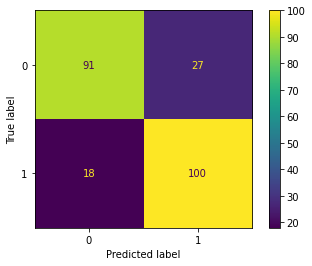

In [1553]:
lr_y_pred=lr.predict(scaler.fit_transform(X_test))
print(sklearn.metrics.classification_report(y_test, lr_y_pred))

cm = confusion_matrix(y_test, lr_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [1554]:
# def f_importances(coef, names):
#     imp = coef
#     imp,names = zip(*sorted(zip(imp,names)))
#     plt.barh(range(len(names)), imp, align='center')
#     plt.yticks(range(len(names)), names)
#     plt.show()
# f_importances(clf.coef_, generate_column_names())

In [1555]:
# stop

In [1556]:
def drop_space(arr):
    new_arr=[]
    for el in arr:
        if el!='':
            new_arr.append(el)
    return new_arr
def report2rows(y_test,y_pred):
    split_table=str(sklearn.metrics.classification_report(y_test, y_pred)).split('\n')
    table2=[]*len(split_table)
    for st in split_table:
        st=st.strip()
        to_add=drop_space(st.split('  '))
        if len(to_add)>1:
            if drop_space(to_add)[0]=='accuracy':
                to_add=[to_add[0],'','',to_add[1],to_add[2]]
            if drop_space(to_add)[0]=='precision':
                to_add=['',to_add[0],to_add[1],to_add[2],to_add[3]]
            if drop_space(to_add)[0]=='2.0':
                to_add[0]='preictal'
            if drop_space(to_add)[0]=='0.0':
                to_add[0]='interictal'
            table2.append(to_add)
    return table2

In [1557]:
report2rows(y_test,clf.predict(Sc_X_test))

[['', 'precision', 'recall', 'f1-score', ' support'],
 ['interictal', ' 0.74', '0.86', '0.80', ' 118'],
 ['preictal', ' 0.84', '0.69', '0.76', ' 118'],
 ['accuracy', '', '', ' 0.78', ' 236'],
 ['macro avg', ' 0.79', '0.78', '0.78', ' 236'],
 ['weighted avg', ' 0.79', '0.78', '0.78', ' 236']]

In [1558]:
def return_metrics(y_test,y_pred):
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test, y_pred).ravel()
    specificity=(tn)/(tn+fp)
    sensitivity=(tp)/(tp+fn)
    f1_score=sklearn.metrics.f1_score(y_test, y_pred, average='micro')
    auc=sklearn.metrics.roc_auc_score(y_test, y_pred)

    return [list(sklearn.metrics.confusion_matrix(y_test, y_pred).ravel()),[specificity, sensitivity, f1_score, auc]]

## Write Results:

In [1559]:
svm_pred=clf.predict(Sc_X_test)
rf_pred=rf.predict(Sc_X_test)
lr_pred=lr.predict(Sc_X_test)
import csv
with open('results_temp.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['10sec_notwelch'])
    writer.writerow(['periodogram','10','diff','frequency only'])
    writer.writerow(["SVM"])
    writer.writerow(['TN',	'FP',	'FN',	'TP'])
    writer.writerow(return_metrics(y_test, svm_pred)[0])
    writer.writerow(['specificity','sensitivity','f1-score','auc'])
    writer.writerow(return_metrics(y_test, svm_pred)[1])
    writer.writerows(report2rows(y_test,clf.predict(Sc_X_test)))
    writer.writerow(["RF"])
    writer.writerow(['TN',	'FP',	'FN',	'TP'])
    writer.writerow(return_metrics(y_test, rf_pred)[0])
    writer.writerow(['specificity','sensitivity','f1-score','auc'])
    writer.writerow(return_metrics(y_test, rf_pred)[1])
    writer.writerows(report2rows(y_test,rf.predict(Sc_X_test)))
    writer.writerow(["LR"])
    writer.writerow(['TN',	'FP',	'FN',	'TP'])
    writer.writerow(return_metrics(y_test, lr_pred)[0])
    writer.writerow(['specificity','sensitivity','f1-score','auc'])
    writer.writerow(return_metrics(y_test, lr_pred)[1])
    writer.writerows(report2rows(y_test,lr.predict(Sc_X_test)))




# Testing on a new patient

In [1560]:
# df10=pd.DataFrame(data=X_10, columns=generate_column_names())
df10=df[df['patient']==9]
df10=df10[(df10['target']==2) | (df10['target']==0) ]
# df10['target']=y_10
# print(df10.shape)
# df10=df10.dropna()
# print(df10.shape)
# df10.reset_index(drop=True, inplace=True)
# df10=df10[(df10['target']==0) | (df10['target']==2)]
# print(df10['target'].max())
# df10=df10[(df10['patient']==10) ]
df10
# X_10_test  =np.array(test_df[df.columns[-1]]).astype('float32')


,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,FT10-T8-2,FT10-T8-3,FT10-T8-4,FT10-T8-5,FT10-T8-6,FT10-T8-7,FT10-T8-8,patient,target,file
15042,0.133061,0.408739,0.102874,0.128785,0.122062,0.026916,0.093007,0.028220,842.484741,0.085132,...,0.006792,0.039070,0.253233,0.074316,0.302595,0.092817,3637.978760,9.0,0,17920
15043,0.140891,0.466610,0.093273,0.097230,0.107099,0.030314,0.105131,0.030467,788.133667,0.025396,...,0.002077,0.006959,0.251287,0.081245,0.360280,0.127815,7657.804688,9.0,0,17920
15044,0.039498,0.141252,0.017832,0.022564,0.162640,0.051804,0.432038,0.117905,3364.845215,0.009816,...,0.001286,0.004496,0.223158,0.068707,0.380546,0.152550,15112.115234,9.0,0,17920
15045,0.014389,0.081509,0.004549,0.007157,0.143349,0.055358,0.405242,0.233103,12884.056641,0.005721,...,0.001282,0.004157,0.221799,0.070101,0.382677,0.153492,13043.042969,9.0,0,17920
15046,0.015849,0.085399,0.007605,0.010672,0.138365,0.055077,0.377824,0.251463,10708.702148,0.006997,...,0.001809,0.005541,0.226428,0.081926,0.398249,0.128052,7843.775391,9.0,0,17920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20356,0.144448,0.427665,0.010794,0.060860,0.188358,0.028397,0.150466,0.040534,650.253540,0.084454,...,0.006756,0.079838,0.158935,0.030025,0.458007,0.033908,1392.175781,9.0,2,20790
20357,0.008058,0.065080,0.001055,0.003260,0.167751,0.074446,0.457628,0.167673,21259.822266,0.004211,...,0.006937,0.050111,0.150528,0.028558,0.491798,0.033452,1358.142822,9.0,2,20790
20358,0.006507,0.063201,0.001070,0.003140,0.167712,0.074684,0.459481,0.168300,21164.937500,0.004258,...,0.007688,0.072927,0.157404,0.041710,0.472756,0.028251,1235.827881,9.0,2,20790
20359,0.009361,0.074405,0.000872,0.004321,0.155929,0.091190,0.452610,0.175899,13022.469727,0.005038,...,0.009113,0.094715,0.155390,0.055030,0.457105,0.032061,1256.976440,9.0,2,20790


In [1561]:
df10['patient'].unique()

array([9.])

In [1562]:
df10=df10.drop(['patient'], axis=1)

In [1563]:
df10[df10.drop('target', axis=1).columns]

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,FT10-T8-0,FT10-T8-1,FT10-T8-2,FT10-T8-3,FT10-T8-4,FT10-T8-5,FT10-T8-6,FT10-T8-7,FT10-T8-8,file
15042,0.133061,0.408739,0.102874,0.128785,0.122062,0.026916,0.093007,0.028220,842.484741,0.085132,...,0.037112,0.173419,0.006792,0.039070,0.253233,0.074316,0.302595,0.092817,3637.978760,17920
15043,0.140891,0.466610,0.093273,0.097230,0.107099,0.030314,0.105131,0.030467,788.133667,0.025396,...,0.010027,0.132605,0.002077,0.006959,0.251287,0.081245,0.360280,0.127815,7657.804688,17920
15044,0.039498,0.141252,0.017832,0.022564,0.162640,0.051804,0.432038,0.117905,3364.845215,0.009816,...,0.007553,0.096018,0.001286,0.004496,0.223158,0.068707,0.380546,0.152550,15112.115234,17920
15045,0.014389,0.081509,0.004549,0.007157,0.143349,0.055358,0.405242,0.233103,12884.056641,0.005721,...,0.010066,0.091628,0.001282,0.004157,0.221799,0.070101,0.382677,0.153492,13043.042969,17920
15046,0.015849,0.085399,0.007605,0.010672,0.138365,0.055077,0.377824,0.251463,10708.702148,0.006997,...,0.012916,0.116215,0.001809,0.005541,0.226428,0.081926,0.398249,0.128052,7843.775391,17920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20356,0.144448,0.427665,0.010794,0.060860,0.188358,0.028397,0.150466,0.040534,650.253540,0.084454,...,0.070400,0.186153,0.006756,0.079838,0.158935,0.030025,0.458007,0.033908,1392.175781,20790
20357,0.008058,0.065080,0.001055,0.003260,0.167751,0.074446,0.457628,0.167673,21259.822266,0.004211,...,0.071708,0.194683,0.006937,0.050111,0.150528,0.028558,0.491798,0.033452,1358.142822,20790
20358,0.006507,0.063201,0.001070,0.003140,0.167712,0.074684,0.459481,0.168300,21164.937500,0.004258,...,0.057512,0.186947,0.007688,0.072927,0.157404,0.041710,0.472756,0.028251,1235.827881,20790
20359,0.009361,0.074405,0.000872,0.004321,0.155929,0.091190,0.452610,0.175899,13022.469727,0.005038,...,0.063046,0.167651,0.009113,0.094715,0.155390,0.055030,0.457105,0.032061,1256.976440,20790


In [1564]:
X_10_test  =np.array(df10.drop('target', axis=1)).astype('float32')
y_10_test  =np.array(df10['target']).astype('float32')


In [1565]:
test_10=clf.predict(X_10_test)
test_10.shape

ValueError: X.shape[1] = 199 should be equal to 198, the number of features at training time

In [ ]:
tes_10_score = clf.score(X_10_test, y_10_test)
tes_10_score

ValueError: Found array with 0 sample(s) (shape=(0, 201)) while a minimum of 1 is required.

In [ ]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_10_test, test_10).ravel()
print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))
specificity=(tn)/(tn+fp)
sensitivity=(tp)/(tp+fn)
f1_score=sklearn.metrics.f1_score(y_10_test, test_10,pos_label=2)

print('specificity= {} , sensitivity= {}, f1= {}'.format(specificity, sensitivity, f1_score))

TN:1561, FP:12462, FN:3, TP:403
specificity= 0.11131712187121158 , sensitivity= 0.9926108374384236, f1= 0.06073393112802352


In [ ]:
df_results16=pd.DataFrame({'real':y_10_test, 'predicted':test_10})
df_results16


,real,predicted
0,0.0,2.0
1,0.0,2.0
2,0.0,2.0
3,0.0,2.0
4,0.0,2.0
...,...,...
14424,0.0,2.0
14425,0.0,2.0
14426,0.0,2.0
14427,0.0,2.0


In [ ]:
def smooth(ser):
    window=5
    i=0
    while i < len(ser)-window:
        if ser[i]==ser[i+window]:
            ser[i:i+window]=ser[i]
        i+=1
    return np.array(ser)

In [ ]:
import statistics
def smooth_mode(ser):
    window=11
    i=0
    while i < len(ser)-window:
        ser[i:i+window]=statistics.mode(ser[i:i+window])
        i+=window
    return np.array(ser)

In [ ]:
smooth_pred=smooth(test_10)
smooth_pred

array([2., 2., 2., ..., 2., 2., 2.], dtype=float32)

In [ ]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_10_test, smooth_pred).ravel()
print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))
specificity=(tn)/(tn+fp)
sensitivity=(tp)/(tp+fn)
f1_score=sklearn.metrics.f1_score(y_10_test, smooth_pred, pos_label=2)

print('specificity= {} , sensitivity= {}, f1= {}'.format(specificity, sensitivity, f1_score))

TN:1321, FP:12702, FN:0, TP:406
specificity= 0.0942023818013264 , sensitivity= 1.0, f1= 0.060085836909871244


In [ ]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_10_test, smooth_mode(test_10)).ravel()
print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))
specificity=(tn)/(tn+fp)
sensitivity=(tp)/(tp+fn)
f1_score=sklearn.metrics.f1_score(y_10_test, smooth_mode(test_10), pos_label=2)

print('specificity= {} , sensitivity= {}, f1= {}'.format(specificity, sensitivity, f1_score))

StatisticsError: no unique mode; found 2 equally common values

In [ ]:
stop

NameError: name 'stop' is not defined

### grid search

In [ ]:
from numpy import mean
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
balance = [{0:10,2:1}, {0:1,2:1}, {0:1,2:10}, {0:1,2:15}, {0:1,2:20}]
costs=[1.0,10.0,100.0, 150.0,1000.0]
# balance = [{0:1,2:10}, {0:1,2:15}]
# costs=[1.0]
param_grid = dict(C=costs, class_weight=balance)

In [ ]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
grid = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1_macro')


In [ ]:
grid_result = grid.fit(Sc_X_train, y_train)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.986212 using {'C': 100.0, 'class_weight': {0: 1, 2: 10}}
0.958576 (0.004747) with: {'C': 1.0, 'class_weight': {0: 10, 2: 1}}
0.964502 (0.007789) with: {'C': 1.0, 'class_weight': {0: 1, 2: 1}}
0.951377 (0.006678) with: {'C': 1.0, 'class_weight': {0: 1, 2: 10}}
0.948806 (0.005731) with: {'C': 1.0, 'class_weight': {0: 1, 2: 15}}
0.948292 (0.005766) with: {'C': 1.0, 'class_weight': {0: 1, 2: 20}}
0.985702 (0.004929) with: {'C': 10.0, 'class_weight': {0: 10, 2: 1}}
0.984169 (0.005134) with: {'C': 10.0, 'class_weight': {0: 1, 2: 1}}
0.985956 (0.003947) with: {'C': 10.0, 'class_weight': {0: 1, 2: 10}}
0.985956 (0.003947) with: {'C': 10.0, 'class_weight': {0: 1, 2: 15}}
0.985956 (0.003947) with: {'C': 10.0, 'class_weight': {0: 1, 2: 20}}
0.985957 (0.004629) with: {'C': 100.0, 'class_weight': {0: 10, 2: 1}}
0.985957 (0.004629) with: {'C': 100.0, 'class_weight': {0: 1, 2: 1}}
0.986212 (0.004862) with: {'C': 100.0, 'class_weight': {0: 1, 2: 10}}
0.986212 (0.004862) with: {'C': 100.0, 'cla